# Brain Tumor Classification
## Machine Learning (CAP-5610) Final Project
## Authors: Kieran O'Sullivan, Lou Vaughn, Duc Nguyen

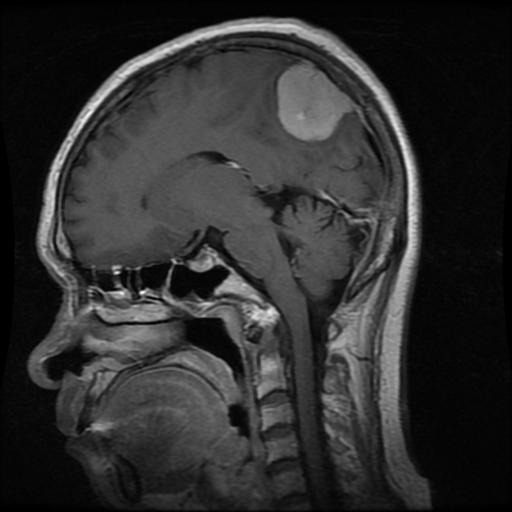

# SECTION 1 - INTRODUCTION

## Project Background

Brain tumors are a feared diagnoses for many, and are complex in that there are abnormalities in their size and location that make it difficult to manually diagnose. Professional neurosurgeons are often required for MRI analysis and a diagnosis of brain tumors, and an accurate diagnosis is extremely important for treatment. The goal of this project was to fine-tune an image-classification model for the purpose of analyzing brain scans to reach one of the following four diagnoses:


*   No Tumor
*   Glioma Tumor
*   Meningioma Tumor
*   Pituitary Tumor

In this notebook, we will discuss the dataset, the methods used, and the results of the analysis.




## Data Overview

The dataset selected for this task is the Brain Tumor Classification (MRI) dataset found on Kaggle, at https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data. The data contains hundreds of brain scans (MRI's), and multiple angles of the MRI's are present (overhead, side-profile). Each image is labeled, and pre-sorted into training and testing splits by the uploader. A breakdown of the label representation is seen in the chart below. In total, there are 3264 images.

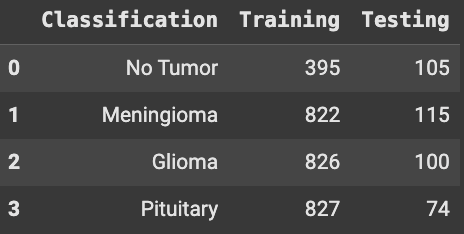

## Model Selection

Training a machine learning model for such a task would likely require a larger dataset, and enormous computational power. Given the limitations on dataset size and hardware available, it was recommended to utilize a pre-trained ML model to conquer this task, and fine tune the hyperparameters to investigate which configuration is best for our purpose. This method saves a large amount of time and resources, allows us to utilize the model's "basic" capabilities (detection of edges, shapes, colors in image), and provides better results.

The model selected is the Vision Transformer (ViT). ViT is a Transformer model, which is a neural network that implements self-attention. Self-attention is the mechanism that helps the model learn what aspects of the image are important, rather than just "seeing" the entire image. This can be thought of as simulating a radiologist looking at the image manually - they are not going to be concerned with every pixel of the MRI, and rather look for a specific chunk(s) of the image that is relevant. ViT is pre-trained on the ImageNet-21k dataset, which contains 14 million images of different real-world objects, and labeled by what is the main subject of the picture. This makes it a strong candidate for our use. The following code acquired the model for us using the transformers library.

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForImageClassification.from_pretrained(checkpoint, num_labels = 4)

# SECTION 2 - TECHNICAL IMPLEMENTATION

## Preprocessing Images

Before the ViT can be trained on our dataset, we must transform each image to be fed into the model. As such, the images are converted to 224x224 tensors. This standardizes all the images, ensuring they are all of the same size. Additionally, this is what the original ViT was trained on, so it is important to maintain that structure.

## Model

With the images transformed and the model acquired, we begin to train the model. For early iterations of the model, the main hyperparameters adjusted were:
*   Epoch - # of passes through training set
*   Weight Decay - penalty applied to reduce weights and counter overfitting
*   Batch Size - # of samples processed at a time

In later iterations, learning rate (size of updates made to model weights) was lowered and two techniques additional techniques were employed: Freezing and Progressive Unfreezing.



## Freezing

In some iterations of training, a technique called Freezing was employed. This concept refers to telling the model to not update its weights in specified layers. The idea behind this is that the model may not need to re-train every single layer for our task. Specifically, early layers (which contribute to learning basic visual features) may not need to be trained again as they are less task-specific. The application of freezing was to help with overfitting seen in early iterations of the model.

## Progressive Unfreezing

Progressive Unfreezing is the process of gradually unfreezing more and more of the model as training progresses. It prevents early overfitting on small datasets by allowing the model to gradually adapt to the MRI Tumor Classification task. The key downside of progressive freezing is that it does not retain its memories of what the data looks like between freezing stages, meaning each level starts with a limited context. As a result it may be struggling to learn effectively with too few epochs.

# SECTION 3 - MODEL DISCUSSION

## Results

Multiple different combinations of model hyperparameters were tested, and are documented in the below chart. At first, the basic hyperparameter changes were tested. In further iterations, the addition of freezing specific groups of layers or singular layers was attempted. The application of freezing did not show any significant improvement over the first few models, however it did perform better than many other configurations.

*In model #8, progressive unfreezing is applied. Every 3 epochs, one layer is unfrozen, starting with layer 8, then 6, then, 4. Unfortunately, this also did not improve the models performance over earlier iterations.

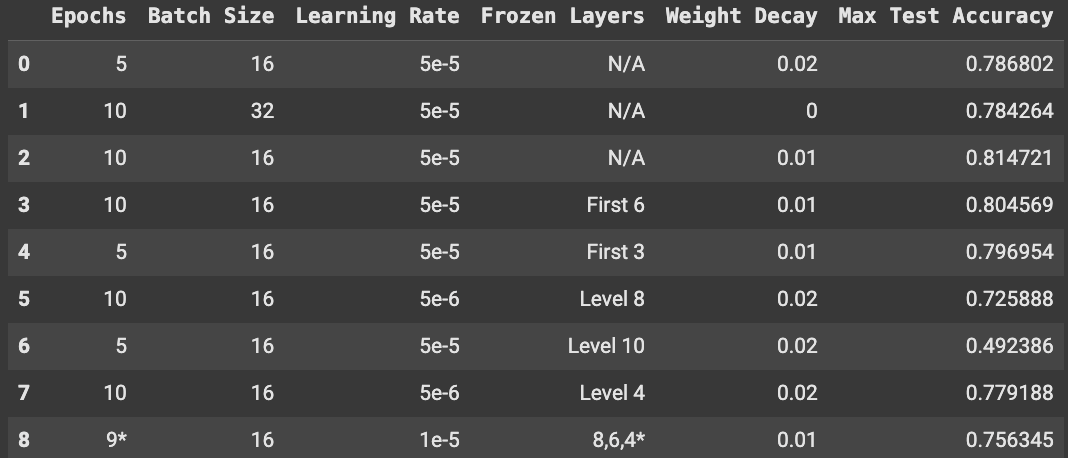

## Champion Model

The champion model, based on the highest accuracy, is model #2 in the table above. This iteration - much like all of the others - is still suffering from an overfitting issue. This is made clear by the steep decrease in training loss, but steadiness (and slight increase) in validation loss across the epochs. Accuracy peaks at ~81.47% after the 2nd epoch, but settles in at just over 80% by the end of training. The per epoch metrics can be seen in the below table for the champion model.

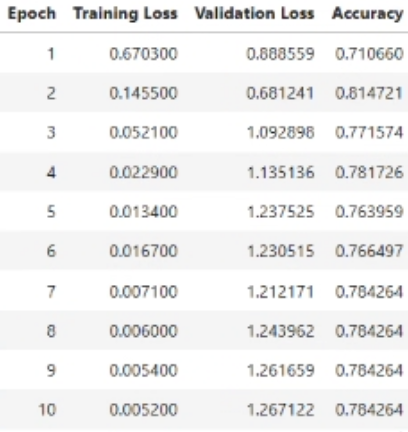

A visual representation of the above loss and accuracy values. As mentioned, the training loss converges to 0, while validtion loss increases to and stays above 1 for the duration. The validation accuracy peaks at 0.814, but declines and levels out at 0.784.

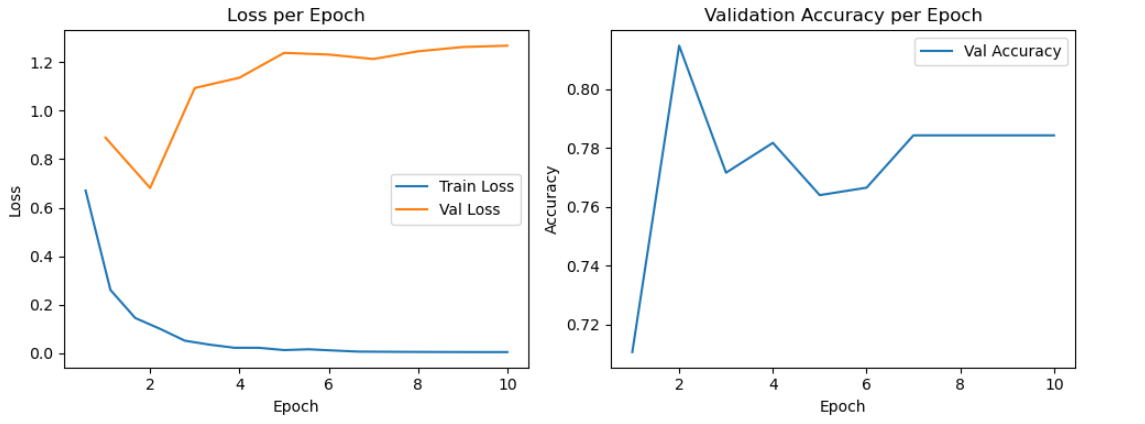

Diving deeper into the success of the champion model, the below classification report provides insights into how the model is fairing for each class. The recall column (when scan shows class X, how many times did model predict class X) clearly shows that the model struggles most with the glioma tumor type, only predicting glioma for 23% of true glioma tumors. Interestingly, its precision score is 1.00, meaning every time the model predicted glioma, it was correct, however missing 77% of glioma tumors in scans is undoubtedly a failure for the purpose of diagnosing patients.

The other three classes show much better results, with no tumor and meningioma tumor classes having perfect recall. Of note however, no tumor is predicted 26% of the time when the correct label is one of the three tumor classes. In our context, about 1 in 4 patients would have their brain tumor (of any kind) undiagnosed by this model.

The difference in performance is likely not due to the representation of each class, given that each "tumor-present" class is relatively balanced in the dataset. In fact, pituitary tumor has the least representation of the three tumor types, and has an impressive f1-score (harmonic mean of precision and recall) of 92%, the highest of all four classes.

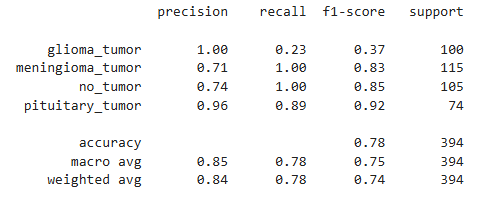

## Sample Model Output

Using the chosen champion model, we can select an individual image at random from the test dataset and evaluate the model's decision. Below, an image with label "pituitary tumor" is selected, and the model generates probabilities of each class. We observe that with 99.57% probability, the model selects the correct class for the image, with each other class less than 0.2% probability.

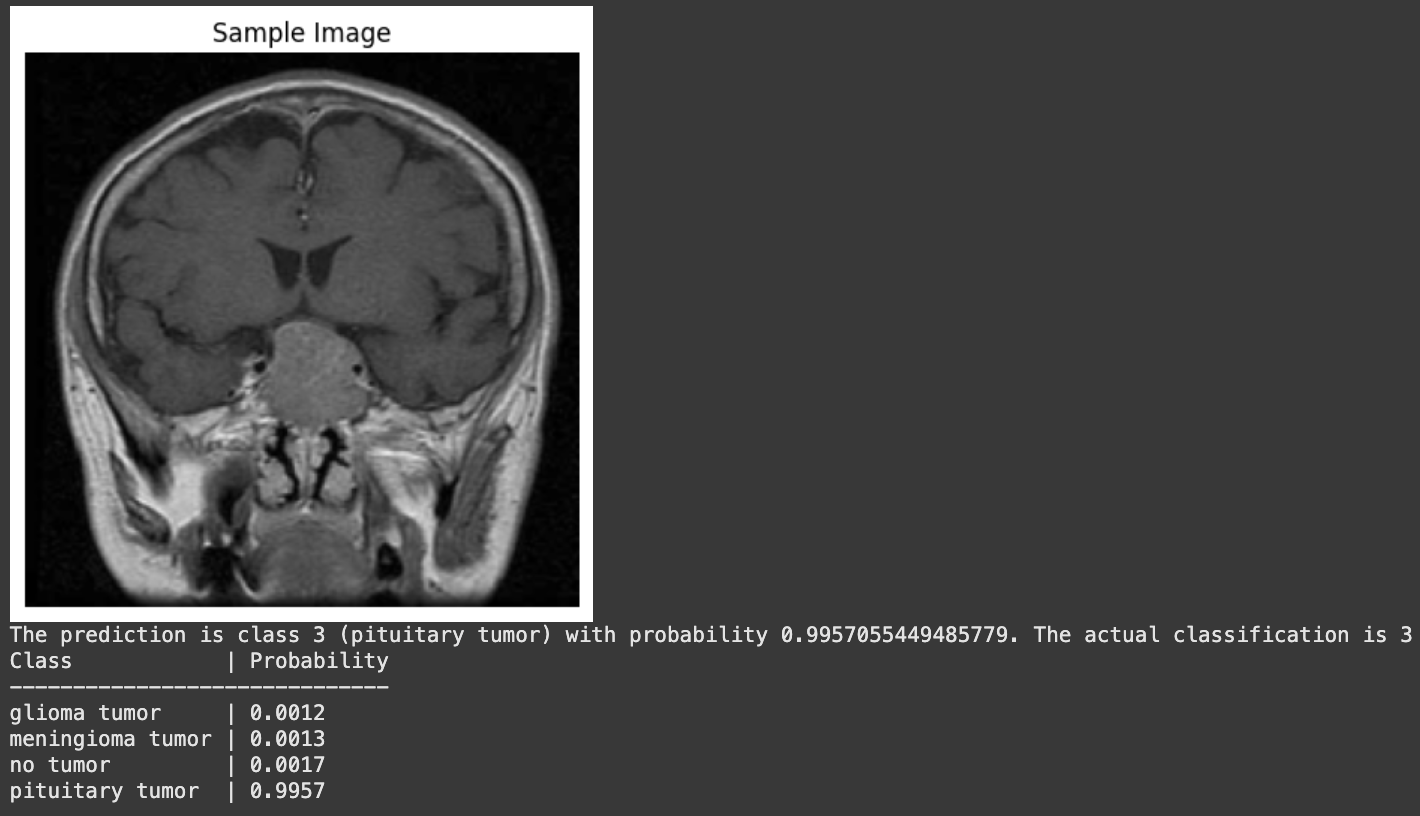

# SECTION 4 - CONCLUSION

Throughout this process, model improvement appeared to be marginal, with most iterations of the fine-tuned model hovering at or below 80% validation accuracy, while a couple have overly negative effects. Freezing and progressive unfreezing did not have significant impact on the models overfitting issue as we had hoped.

Even in the best iteration of our model, overfitting appears to be an issue, made clear by the training loss converging to 0, while validation loss remains above or around 1. The model struggles the most with glioma tumors, but displays high marks with the other three classes. At its best, this model would serve as a fairly accurate classifier for identifying if a brain scan shows a meningioma, pituitary, or no tumor, but not perfect by any means necessary.


The largest limitation faced by our group was processing power. Even with GPU computing, model training times ranged from 15 minutes up to over an hour. Google Colab provided an alternative to training the model in a local environment and has stronger computing power, however, this also comes with caveats. Namely, any generated or uploaded files are not permanently stored in the enviornment, and are purged when disconnected from the Runtime. Additionally, GPU access time is limited in Colab.

# APPENDIX

## Code Implentation

For code implementation of above methods, please see attached BrainTumor.ipynb file. Instructions to run are also included in that file.

## Dataset Breakdown Chart

In [ ]:
import pandas as pd

data = {
    'Classification': ['No Tumor', 'Meningioma', 'Glioma', 'Pituitary'],
    'Training': ['395','822','826','827'],
    'Testing': ['105','115','100','74']
}
data_breakdown_chart = pd.DataFrame(data)
data_breakdown_chart

,Classification,Training,Testing
0,No Tumor,395,105
1,Meningioma,822,115
2,Glioma,826,100
3,Pituitary,827,74


## Results Chart

In [ ]:
import pandas as pd


results_data = {
    'Epochs': ['5','10','10','10','5','10','5','10','9*'],
    'Batch Size': ['16','32','16','16','16','16','16','16','16'],
    'Learning Rate': ['5e-5','5e-5','5e-5','5e-5','5e-5','5e-6','5e-5','5e-6','1e-5'],
    'Frozen Layers': ['N/A','N/A','N/A','First 6','First 3','Level 8','Level 10','Level 4','8,6,4*'],
    'Weight Decay': ['0.02','0','0.01','0.01','0.01','0.02','0.02','0.02','0.01'],
    'Max Test Accuracy': ['0.786802','0.784264','0.814721','0.804569','0.796954','0.725888','0.492386','0.779188','0.756345'],
}
results_chart = pd.DataFrame(results_data)
results_chart

,Epochs,Batch Size,Learning Rate,Frozen Layers,Weight Decay,Max Test Accuracy
0,5,16,5e-5,N/A,0.02,0.786802
1,10,32,5e-5,N/A,0,0.784264
2,10,16,5e-5,N/A,0.01,0.814721
3,10,16,5e-5,First 6,0.01,0.804569
4,5,16,5e-5,First 3,0.01,0.796954
5,10,16,5e-6,Level 8,0.02,0.725888
6,5,16,5e-5,Level 10,0.02,0.492386
7,10,16,5e-6,Level 4,0.02,0.779188
8,9*,16,1e-5,"8,6,4*",0.01,0.756345
